# Credit Risk PD Interpolation Project Using numerical methods

In this project, we use the **Give Me Some Credit** dataset to:

- Build a simple risk index based on utilization, debt ratio, and late payments
- Estimate the empirical probability of default (PD)
- Approximate the PD curve using Lagrange, polynomial, and quadratic interpolation


## Dataset Description and Motivation

This project uses the **Give Me Some Credit** dataset, a real-world credit risk dataset containing
financial and behavioral information about borrowers. The target variable,
`SeriousDlqin2yrs`, indicates whether a customer experienced a serious delinquency
(90+ days past due) within two years.

The dataset was chosen because it allows a natural estimation of the **Probability of Default (PD)**
from real financial data. By grouping borrowers with similar risk characteristics, empirical PD
values can be computed and treated as discrete samples of an unknown risk function.

Additionally, the dataset contains meaningful financial variables (such as credit utilization,
delinquency history, and debt ratio) that can be combined into a one-dimensional risk index. This
makes it well suited for applying and comparing **numerical interpolation methods** in a realistic
credit risk context.



In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project paths
ROOT = Path.cwd().parent   # notebooks/ → project root
DATA_DIR = ROOT / "data"
RESULTS_DIR = ROOT / "results"

# Create results folder if it doesn't exist
RESULTS_DIR.mkdir(exist_ok=True)

GMSC_RAW = DATA_DIR / "gmsc_raw.csv"


In [27]:
import pandas as pd

df = pd.read_csv(GMSC_RAW)
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
import pandas as pd

df = pd.read_csv("../data/gmsc_raw.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


- Here we have uploaded the Give me some Credit Dataset to use for our Interpolation project
- To check, we pulled the head of the Data set using the 'head' function
- Using drop function, we removed unwanted column 'Unnamed' for its non-utile for our project

In [6]:
Key_vars = [
    "SeriousDlqin2yrs",
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "NumberOfTimes90DaysLate"
]

df = df.dropna(subset=Key_vars)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

- Since the columns :
                      - **'RevolvingUtilizationOfUnsecuredLines'**
                      - **'DebtRatio'**
                      - **'NumberOfTimes90DaysLate'**
: are the columns affecting the most our "risk_index", we will have to remove any rows containing missing data in these columns

- In the purpose of having a clean and well-structured data set, we removed unwanted rows that contains NaN using the function 'dropna()' and 'subset()' to choose only the columns we want.

- Finally to review the final result we use the function 'info()'

In [7]:
df["RevolvingUtilizationOfUnsecuredLines"] = (
    df["RevolvingUtilizationOfUnsecuredLines"].clip(0,1)
)

df["DebtRatio"] = df["DebtRatio"].clip(0,5)

df["NumberOfTimes90DaysLate"] = df["NumberOfTimes90DaysLate"].clip(0,5)

df[["RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "NumberOfTimes90DaysLate"]].describe()

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,NumberOfTimes90DaysLate
count,150000.000000,150000.000000,150000.000000
mean,0.319196,1.286963,0.096187
std,0.349481,1.884544,0.485005
min,0.000000,0.000000,0.000000
25%,0.029867,0.175074,0.000000
50%,0.154181,0.366508,0.000000
75%,0.559046,0.868254,0.000000
max,1.000000,5.000000,5.000000


- Extreme values (data entry erros, anomalies, unrealistic profiles) can dominate the rest of the values and affect our **risk_index**

- Therefore, to get rid of them, we have used the 'clip()' function to cut values outisde a boundary to end up with values inside a boundary of our chosing.

- "Utilization" is how much credit cards/lines are used. Thus, it should be logically from 0 (no usage) and 1 (100% usage)

- "DebtRatio" is monthly debt/monthly income, where values > 5 mean the person claims to have debt = 500% of income which os rare and destructive for models, we cap at 5 as max risky

- For a simple risk index, if someone was 90+ days late 7 times, it is not much worse than 5 time. Therefore, both should be considered "max risk"

In [8]:
df["util_norm"] = df["RevolvingUtilizationOfUnsecuredLines"]

df["debt_norm"] = df["DebtRatio"] / 5.0

df["late_norm"] = df["NumberOfTimes90DaysLate"] / 5.0

df[["util_norm", "debt_norm", "late_norm"]].head()

,util_norm,debt_norm,late_norm
0,0.766127,0.160596,0.0
1,0.957151,0.024375,0.0
2,0.658180,0.017023,0.2
3,0.233810,0.007210,0.0
4,0.907239,0.004985,0.0


# Normalization

- Parameters in credit datasets have very different scales, and for our parameters to be combined for our **"risk Index" (y axis)** they need similar ranges.

- Normalization puts everything into *0* and *1*, making weight assignement easy and fair, where values falling to 1 are extremely high debt for **debt_norm** or extremely risky for **late_norm**.

In [9]:
df["risk_index"] = (
    0.3 * df["util_norm"] +
    0.3 * df["debt_norm"] +
    0.4 * df["late_norm"]
)

df["risk_index"].describe()

count    150000.000000
mean          0.180671
std           0.161558
min           0.000000
25%           0.036809
50%           0.132700
75%           0.304742
max           1.000000
Name: risk_index, dtype: float64

# Risk Index (x-axis)

- As explained in the last step, we need our risk parameters to be combined in one parameter which is *risk_index*

- Based on expert reasoning, we chose 0.3 for both *utilization* and *debt ratio*, and 0.4 for *late payments* for its strongest predictive risk factor

- Now we are ready to move to **the Probability of default (Y-axis)**

In [10]:
import numpy as np

bins = np.linspace(0, 1, 11)

bins

df["risk_bucket"] = pd.cut(
    df["risk_index"],
    bins = bins,
    include_lowest= True
)

df[["risk_index", "risk_bucket"]].head(10)

grouped = df.groupby("risk_bucket")["SeriousDlqin2yrs"]

pd_table = grouped.mean().reset_index(name="PD") #

pd_table

bucket_centers = []
for interval in pd_table["risk_bucket"]:
    left = interval.left
    right = interval.right
    bucket_centers.append((left + right) / 2)

pd_table["risk_center"] = bucket_centers

pd_table

C:\Users\youss\AppData\Local\Temp\ipykernel_76236\1911909272.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("risk_bucket")["SeriousDlqin2yrs"]


,risk_bucket,PD,risk_center
0,"(-0.001, 0.1]",0.019319,0.0495
1,"(0.1, 0.2]",0.057172,0.1500
2,"(0.2, 0.3]",0.098833,0.2500
3,"(0.3, 0.4]",0.088584,0.3500
4,"(0.4, 0.5]",0.203938,0.4500
5,"(0.5, 0.6]",0.182980,0.5500
6,"(0.6, 0.7]",0.487155,0.6500
7,"(0.7, 0.8]",0.600000,0.7500
8,"(0.8, 0.9]",0.589286,0.8500
9,"(0.9, 1.0]",0.752294,0.9500


In [11]:
pd_table = pd_table.sort_values("risk_center")

x = pd_table["risk_center"].values
y = pd_table["PD"].values

print("Our x *Risk_Index* values are: ", x)

print("Our y *Probability of Default* values are:", y)


Our x *Risk_Index* values are:  [0.0495 0.15   0.25   0.35   0.45   0.55   0.65   0.75   0.85   0.95  ]
Our y *Probability of Default* values are: [0.01931892 0.05717237 0.09883307 0.08858361 0.20393812 0.18298042
 0.48715509 0.6        0.58928571 0.75229358]


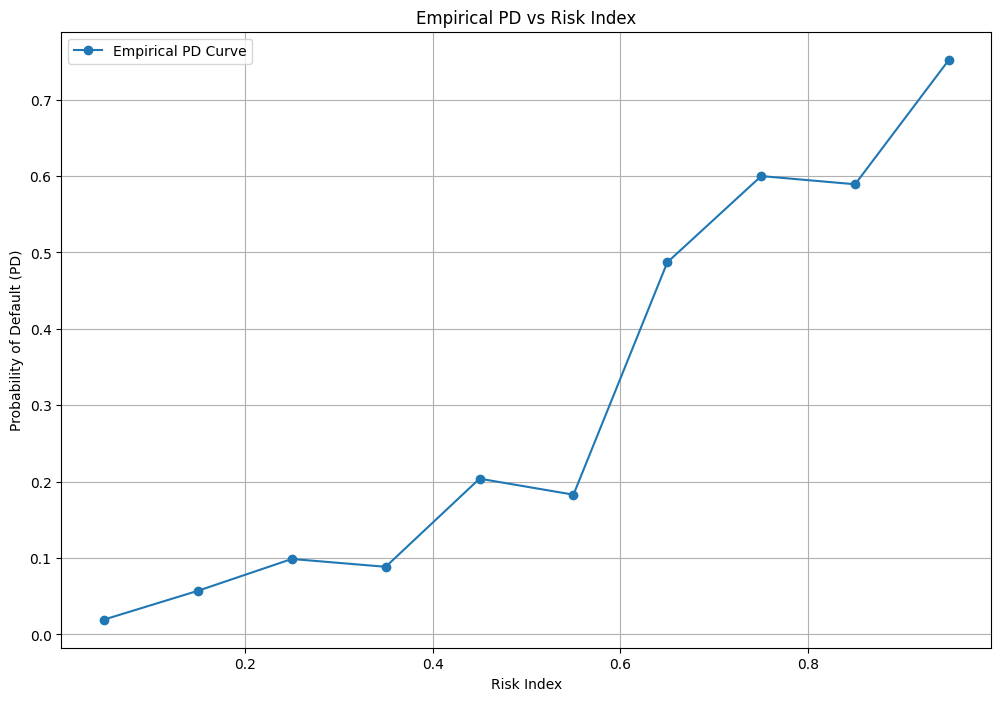

In [12]:
plt.figure(figsize=(12,8))
plt.plot(x, y, 'o-', label="Empirical PD Curve")
plt.xlabel("Risk Index")
plt.ylabel("Probability of Default (PD)")
plt.title("Empirical PD vs Risk Index")
plt.grid(True)
plt.legend()
plt.show()

# Probability of Default vs Risk Index Graph

The PD vs Risk Index graph represents discrete empirical estimates of the Probability of Default obtained through risk bucketing. Each point corresponds to the average default rate within a given risk interval.

This graph is not a continuous function, but a sampled and noisy approximation of an unknown underlying PD function, which motivates the use of interpolation methods.

Since the empirical PD is only available at discrete risk levels and is affected by sampling noise, interpolation is used to construct continuous approximations of the PD function. This allows estimation of PD at intermediate risk values and enables analysis of smoothness, stability, and numerical behavior.

In [13]:
def select_nodes(x, y, n_nodes):
    idx = np.round(np.linspace(0, len(x)-1, n_nodes)).astype(int)
    return x[idx], y[idx]

In [14]:
x10, y10 = select_nodes(x, y, 10)
x7, y7 = select_nodes(x, y, 7)
x5, y5 = select_nodes(x, y, 5)

In [15]:
def lagrange_interpolate(x_nodes, y_nodes, x_eval):
    """
    Compute Lagrange interpolation polynomial evaluated at points x_eval.
    
    x_nodes: known x-values
    y_nodes: known y-values
    x_eval: points where we want the interpolation result
    
    Returns: y_eval (interpolated values)
    """
    y_eval = []
    
    # Loop over each evaluation point
    for x0 in x_eval:
        L = 0
        # Lagrange formula
        for i in range(len(x_nodes)):
            li = 1
            for j in range(len(x_nodes)):
                if i != j:
                    li *= (x0 - x_nodes[j]) / (x_nodes[i] - x_nodes[j])
            L += y_nodes[i] * li
        y_eval.append(L)
    
    return np.array(y_eval)


In [16]:
y_lagrange = lagrange_interpolate(x7, y7, x)

## Lagrange Interpolation Method

In this step, we apply **Lagrange interpolation** to approximate the relationship between the
**risk index (x-axis)** and the **Probability of Default (PD)**.

The Lagrange method constructs a **single global polynomial** that passes **exactly through all
empirical PD points** obtained from the risk buckets. This means that for every observed data point
\((x_i, PD_i)\), the interpolated polynomial satisfies:

\[
P(x_i) = PD_i
\]

### Why we use it
Lagrange interpolation is a classical numerical method and provides an exact fit to the given data.
It is useful for understanding how a global polynomial behaves when forced to match all observed
points.

### Limitations
Because the empirical PD values are estimated from real data and contain noise, forcing an exact
fit can lead to **oscillations** between points, especially when the number of points increases.
This phenomenon illustrates the sensitivity of global interpolation methods to noisy data.

In this project, Lagrange interpolation serves as a **baseline method** to highlight numerical
instability when modeling real-world financial data.


In [17]:
def polynomial_fit_interpolate(x_nodes, y_nodes, degree, x_eval):
    coeffs = np.polyfit(x_nodes, y_nodes, degree)
    poly = np.poly1d(coeffs)
    return poly(x_eval)

In [18]:
y_poly5  = polynomial_fit_interpolate(x7, y7, 5, x)
y_poly10 = polynomial_fit_interpolate(x10, y10, 10, x)

C:\Users\youss\AppData\Local\Temp\ipykernel_76236\457529006.py:2: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_nodes, y_nodes, degree)


## Polynomial Interpolation (Fixed Degree)

In this step, we approximate the PD curve using **polynomial interpolation of a fixed degree**
(e.g., degree 5 or degree 10).

Instead of forcing the polynomial to pass exactly through all data points, this approach fits a
polynomial that **minimizes the overall approximation error** between the empirical PD values and
the polynomial curve.

### Why we use it
By limiting the degree of the polynomial, we control the **complexity** of the approximation.
Lower-degree polynomials produce smoother curves, while higher-degree polynomials allow more
flexibility but may introduce oscillations.

This method demonstrates the **trade-off between smoothness and accuracy**, which is a fundamental
concept in numerical analysis.

### Interpretation
- Lower-degree polynomials tend to be more stable but may underfit the data.
- Higher-degree polynomials fit the data more closely but may become unstable in noisy regions.

Polynomial interpolation provides a compromise between exact fitting and numerical stability.


In [19]:
def quadratic_piecewise_interpolate(x_nodes, y_nodes, x_eval):
    y_eval = np.zeros_like(x_eval)
    
    # Loop over segments
    for i in range(len(x_nodes) - 2):
        # Segment's x-range
        x0, x1, x2 = x_nodes[i], x_nodes[i+1], x_nodes[i+2]
        y0, y1, y2 = y_nodes[i], y_nodes[i+1], y_nodes[i+2]
        
        # Fit quadratic to 3 points
        coeffs = np.polyfit([x0, x1, x2], [y0, y1, y2], 2)
        poly = np.poly1d(coeffs)
        
        # Apply to x_eval values inside this range
        mask = (x_eval >= x0) & (x_eval <= x2)
        y_eval[mask] = poly(x_eval[mask])
    
    return y_eval

In [20]:
y_quad = quadratic_piecewise_interpolate(x7, y7, x)

## Quadratic Piecewise Interpolation

In this step, we apply **quadratic piecewise interpolation** to approximate the PD curve.

Instead of fitting a single global polynomial, this method divides the data into **local segments**
and fits a **quadratic polynomial** to each small group of neighboring points. Each quadratic
polynomial is only used within its local interval.

### Why we use it
Piecewise interpolation reduces the influence of distant data points and focuses on **local behavior**.
This makes the method more robust to noise in empirical PD estimates.

### Advantages
- Improved numerical stability
- Reduced oscillations compared to global polynomial methods
- Better alignment with financial intuition, where risk and default probability change gradually

Quadratic piecewise interpolation is particularly well-suited for real-world financial data, where
smooth and monotonic behavior is preferred over exact fitting.


In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def max_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred))


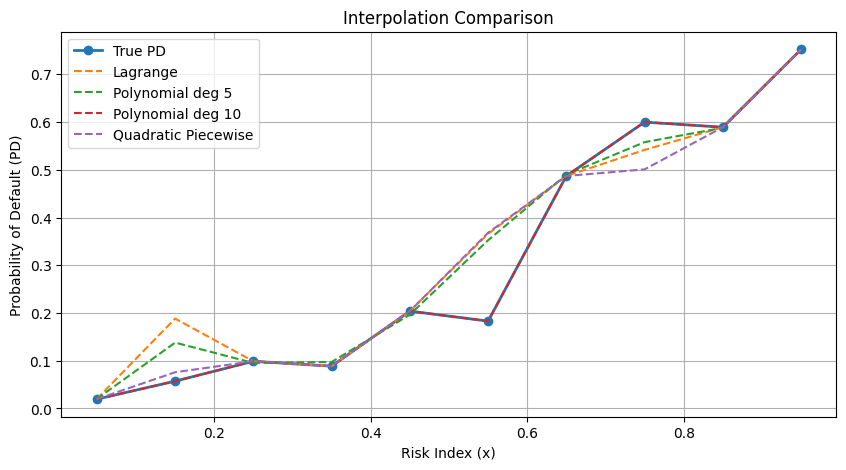

In [22]:
from matplotlib import pyplot as plt


plt.figure(figsize=(10,5))

plt.plot(x, y, 'o-', label="True PD", linewidth=2)

plt.plot(x, y_lagrange, '--', label="Lagrange")
plt.plot(x, y_poly5, '--', label="Polynomial deg 5")
plt.plot(x, y_poly10, '--', label="Polynomial deg 10")
plt.plot(x, y_quad, '--', label="Quadratic Piecewise")

plt.xlabel("Risk Index (x)")
plt.ylabel("Probability of Default (PD)")
plt.title("Interpolation Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Comparison and Interpretation of Interpolation Methods

The three interpolation methods produce different PD curve behaviors due to their underlying
numerical assumptions.

- **Lagrange Interpolation** constructs a single global polynomial that passes exactly through all
  empirical PD points. While this ensures zero error at the data points, it is highly sensitive to
  noise and can exhibit significant oscillations between points.

- **Polynomial Interpolation (Fixed Degree)** provides a smoother approximation by limiting the
  polynomial degree. Lower-degree polynomials offer improved numerical stability but may slightly
  underfit the empirical PD values, while higher-degree polynomials can capture more detail at the
  cost of increased oscillation.

- **Quadratic Piecewise Interpolation** fits local quadratic polynomials over small intervals,
  reducing the influence of distant points. This results in a smoother and more stable PD curve,
  which aligns better with financial intuition and real-world credit risk modeling practices.

Overall, this comparison highlights the trade-off between exact fitting and numerical stability when
interpolating real, noisy financial data.


In [ ]:
# Compute absolute errors at the original x points
error_lagrange = np.abs(y_lagrange - y)
error_poly5 = np.abs(y_poly5 - y)
error_poly10 = np.abs(y_poly10 - y)
error_quad = np.abs(y_quad - y)


In [ ]:
metrics_path = RESULTS_DIR / "interpolation_errors.txt"

with open(metrics_path, "w", encoding="utf-8") as f:
    f.write("Interpolation Error Comparison (GMSC)\n")
    f.write("----------------------------------\n")
    f.write(f"Lagrange RMSE: {rmse_lagrange:.6f}\n")
    f.write(f"Polynomial RMSE: {rmse_poly:.6f}\n")
    f.write(f"Quadratic Piecewise RMSE: {rmse_quad:.6f}\n")

print("Saved metrics to:", metrics_path)


TypeError: unsupported format string passed to numpy.ndarray.__format__

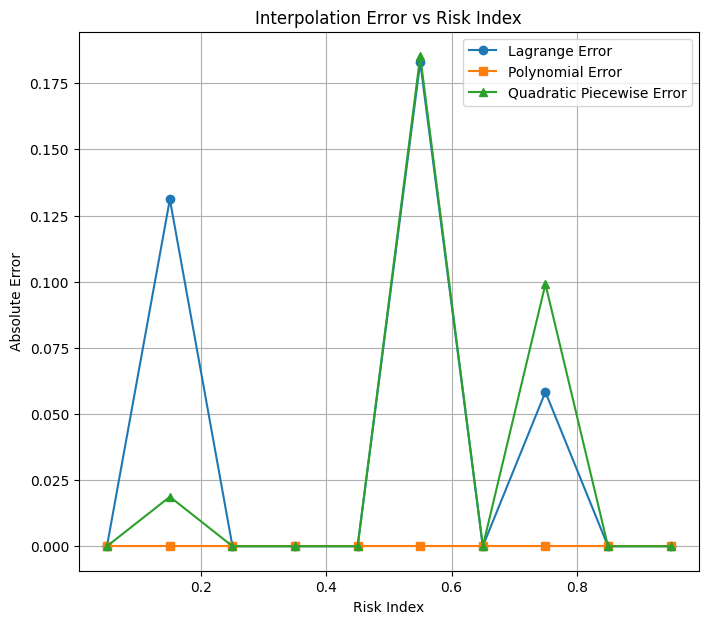

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))

plt.plot(x, error_lagrange, marker='o', label='Lagrange Error')
plt.plot(x, error_poly5, marker='s', label='Polynomial Error')
plt.plot(x, error_poly10, marker='s', label='Polynomial Error')
plt.plot(x, error_quad, marker='^', label='Quadratic Piecewise Error')

plt.xlabel("Risk Index")
plt.ylabel("Absolute Error")
plt.title("Interpolation Error vs Risk Index")
plt.legend()
plt.grid(True)

plt.show()


## Error Analysis

This figure shows the absolute interpolation error as a function of the risk index for each
interpolation method.

The error is computed as the absolute difference between the interpolated PD values and the
empirical PD estimates at the original data points.

The plot illustrates how different interpolation methods distribute error across the risk domain:
- Lagrange interpolation achieves zero error at the data points but may introduce instability
  between points.
- Polynomial interpolation balances approximation accuracy and smoothness.
- Quadratic piecewise interpolation demonstrates more uniform error behavior, indicating improved
  numerical stability.

This analysis further emphasizes the importance of selecting appropriate numerical methods when
working with noisy real-world data.
